<a href="https://colab.research.google.com/github/nicolez9911/colab/blob/main/04_ExerciseCatsandDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cats VS Dogs

Install latest version of kaggle library

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=93a78ec4a076b765357d2890c533933909a5e507a12974f634090c51da0c9b4f
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


1. Create a kaggle account and from your settings create a new API token to download a file called kaggle.json

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nicolez9911","key":"439a3da38e3dab16713f10b91119c5cf"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls ~/.kaggle

kaggle.json


2. Go to this link :https://www.kaggle.com/c/dogs-vs-cats/data
and accept the terms of the competition

In [5]:
!kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:03<00:00, 207MB/s]
100% 812M/812M [00:03<00:00, 240MB/s]


In [6]:
!unzip -qq /content/dogs-vs-cats.zip

In [7]:
!ls /content

dogs-vs-cats.zip  kaggle.json  sample_data  sampleSubmission.csv  test1.zip  train.zip


In [8]:
!unzip -qq /content/train.zip
!unzip -qq /content/test1.zip

**Copying images to training, validation, and test directories**

In [9]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Load Dataset

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
import matplotlib.pyplot as plt

def generate_plot(history):
  # Plot training history (loss and accuracy)
  plt.figure(figsize=(12, 5))

  # Plot training & validation loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')

  # Plot training & validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')

  plt.tight_layout()
  return plt

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 174, 174, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 87, 87, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 242208)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               31002752  
                                                      

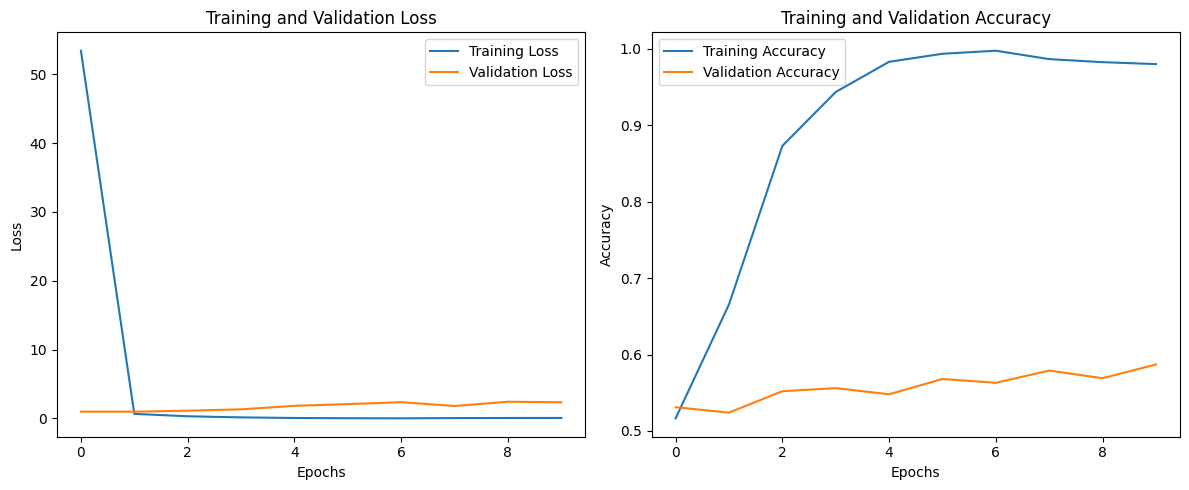

([2.413557529449463, 0.5450000166893005],
 [2.3533377647399902, 0.5870000123977661])

In [14]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10, batch_size=512)

test_loss = model.evaluate(test_dataset)
validation_loss = model.evaluate(validation_dataset)

plt = generate_plot(history)
plt.show()

test_loss, validation_loss


In [16]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
])
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

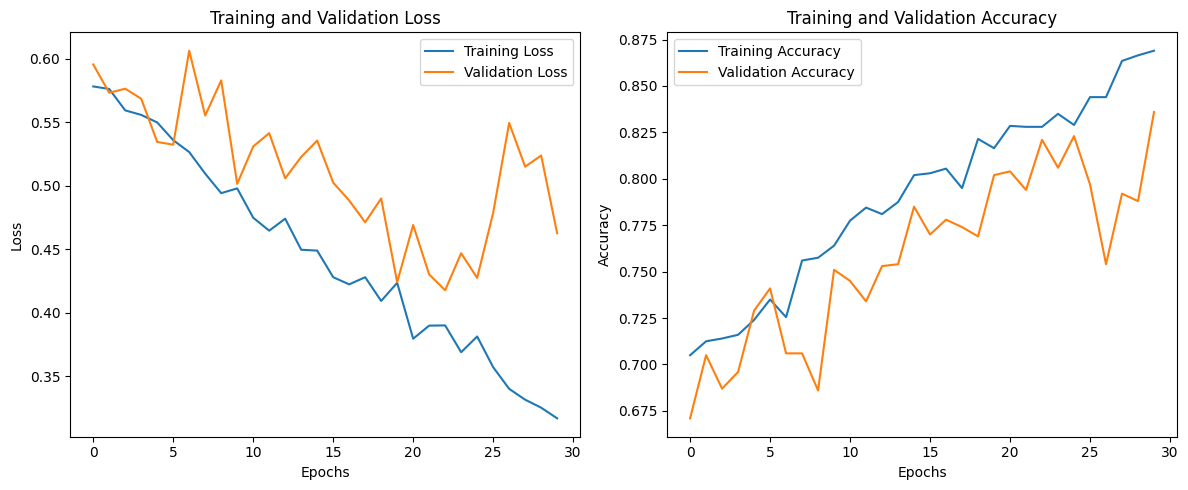

([0.4665664732456207, 0.8209999799728394],
 [0.4626007080078125, 0.8360000252723694])

In [18]:
model.summary()
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=30, batch_size=256)

test_loss = model.evaluate(test_dataset)
validation_loss = model.evaluate(validation_dataset)

plt = generate_plot(history)
plt.show()

test_loss, validation_loss

In [30]:
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False,
  input_shape=(180, 180, 3))
conv_base.summary()

import numpy as np
def get_features_and_labels(dataset) :
  # diese funktion ist dumm
  all_features = []
  all_labels = []

  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate (all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [24]:
conv_base = keras.applications.vgg16.VGG16(
  weights="imagenet",
  include_top=False)
conv_base.trainable = False

In [22]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
  optimizer="rmsprop",
  metrics=["accuracy"])
model.fit(
  train_features, train_labels,
  epochs=20,
  validation_data=(val_features, val_labels))

Epoch 1/20
1/1 [==============================] - 1s 652ms/step - loss: 10.1756 - accuracy: 0.5312 - val_loss: 639.3196 - val_accuracy: 0.4688
Epoch 2/20
1/1 [==============================] - 0s 31ms/step - loss: 587.4122 - accuracy: 0.5000 - val_loss: 46.1504 - val_accuracy: 0.8750
Epoch 3/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 46.1504 - val_accuracy: 0.8750
Epoch 4/20
1/1 [==============================] - 0s 38ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 46.1504 - val_accuracy: 0.8750
Epoch 5/20
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 46.1504 - val_accuracy: 0.8750
Epoch 6/20
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 46.1504 - val_accuracy: 0.8750
Epoch 7/20
1/1 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 46.1504 - val_accuracy: 0.

In [25]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.2),
])
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

In [26]:
model.fit(
train_dataset,
epochs=20,
validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 14s 199ms/step - loss: 18.9537 - accuracy: 0.8910 - val_loss: 15.9112 - val_accuracy: 0.9160
Epoch 2/20
63/63 [==============================] - 10s 147ms/step - loss: 4.2305 - accuracy: 0.9530 - val_loss: 5.9422 - val_accuracy: 0.9500
Epoch 3/20
63/63 [==============================] - 10s 155ms/step - loss: 2.6377 - accuracy: 0.9555 - val_loss: 0.9950 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 10s 151ms/step - loss: 1.0132 - accuracy: 0.9665 - val_loss: 0.7446 - val_accuracy: 0.9520
Epoch 5/20
63/63 [==============================] - 11s 178ms/step - loss: 0.3190 - accuracy: 0.9595 - val_loss: 0.3193 - val_accuracy: 0.9690
Epoch 6/20
63/63 [==============================] - 9s 142ms/step - loss: 0.1900 - accuracy: 0.9670 - val_loss: 0.2328 - val_accuracy: 0.9620
Epoch 7/20
63/63 [==============================] - 9s 144ms/step - loss: 0.1349 - accuracy: 0.9675 - val_loss: 0.2185 - val_accuracy: 0.9760

In [27]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [28]:
model.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
metrics=["accuracy"])

In [29]:
model.fit(
train_dataset,
epochs=20,
validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 13s 170ms/step - loss: 0.1359 - accuracy: 0.9850 - val_loss: 0.3266 - val_accuracy: 0.9720
Epoch 2/20
63/63 [==============================] - 11s 168ms/step - loss: 0.0532 - accuracy: 0.9905 - val_loss: 0.3685 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 11s 168ms/step - loss: 0.0389 - accuracy: 0.9935 - val_loss: 0.3316 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 11s 165ms/step - loss: 0.0452 - accuracy: 0.9900 - val_loss: 0.3085 - val_accuracy: 0.9770
Epoch 5/20
63/63 [==============================] - 10s 162ms/step - loss: 0.0342 - accuracy: 0.9930 - val_loss: 0.2792 - val_accuracy: 0.9730
Epoch 6/20
63/63 [==============================] - 12s 193ms/step - loss: 0.0314 - accuracy: 0.9945 - val_loss: 0.3010 - val_accuracy: 0.9790
Epoch 7/20
63/63 [==============================] - 10s 160ms/step - loss: 0.0469 - accuracy: 0.9930 - val_loss: 0.3134 - val_accuracy: 0.9770